# Basic Arithmetic using quantum circuits


The notebook will be an evaluation of basic arithemetic using carry and add gates and then eventaully the quantum Fourier transform. This is to be a prologue to quantum ordinary differential solver by Zanger.


For reference, we will use the arXiv paper: arXiv:quant-ph/0008033   (this is the paper Zanger based his work on). 

# Quantum circuit of the Classical Carry-Add solver

First we are going solve the classical carry-add solver, but with quantum circuits. The carry gate is made from Toffoli and control-NOT gates. 


The following quantum circuit will compute the addition of two numbers (accounting for overflow) such that they follow the following representation:

Consider the number x with a quantum register is $|x\rangle$ = $|x_n x_{n-1}...x_{2}x_{1}x_{0}\rangle$, where x = $2^0x_0 + 2^1x_1 + 2^2x_2 + ... + 2^{n-1}x_{n-1}$. Or in its binary form x = $x_n x_{n-1}...x_{2}x_{1}x_{0}$.



We want to compute the addition of two numbers a + b = c. Using the code below (following the schematic in arXiv:quant-ph/0008033) we achieve the addition circuit addition of non-negative numbers.

In [1]:
import numpy as np
from qiskit import *
import math
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumCircuit, QuantumRegister
from sympy import *
from math import pi
from qiskit.circuit import Parameter
%matplotlib inline
from scipy.integrate import odeint,solve_ivp
from qiskit.circuit.library.standard_gates import HGate

In [2]:
# Visualization packages
from qiskit.visualization import plot_state_city, plot_bloch_vector,plot_histogram, plot_bloch_multivector
import matplotlib.pyplot as plt

In [3]:
# Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')
backend_vec = Aer.get_backend('statevector_simulator')
backend_uni = Aer.get_backend('unitary_simulator')

In [164]:
# Register circuit (total qubits in the network)
qt = QuantumRegister(4)
ct = ClassicalRegister(4) 

######

qt2 = QuantumRegister(10)
ct2 = ClassicalRegister(10) 

In [120]:
#parameters
N_shots = 10240
N_time = 10000

The carry gate will simply transform the the circuit to account for overflow. 

In [121]:
def Addition_carry_gate(circuit,qb_vec):
    carry = QuantumCircuit(4,name ='carry')
    carry.ccx(1,2,3)
    carry.cx(1,2)
    carry.ccx(0,2,3)
    return circuit.append(carry,qb_vec)

In [177]:
def Addition_carry_dagger_gate(circuit,qb_vec):
    carry = QuantumCircuit(4,name ='carry_inv')
    carry.ccx(1,2,3).inverse()
    carry.cx(1,2).inverse()
    carry.ccx(0,2,3).inverse()
    return circuit.append(carry,qb_vec)

In [186]:
def Addition_sum_gate(circuit,qb_vec):
    sum1 = QuantumCircuit(3,name ='sum')
    sum1.cx(0,2)
    sum1.cx(1,2)
    return circuit.append(sum1,qb_vec)

In [210]:
def Addition_gate(circuit,n, total_bits):
    if (n == 0) or (not n == int(3*total_bits+1)):
        return circuit
    ir = 0
    for i in range(total_bits):
        Addition_carry_gate(circuit,[ir,ir+1,ir+2,ir+3])
        ir = ir+3
    circuit.barrier()
    circuit.cx((n-1)-2,(n-1)-1)
    circuit.barrier()
    Addition_sum_gate(circuit, [(n-1)-3,(n-1)-2,(n-1)-1])
    ir2 = (n-1)-3
    for i in range(int(total_bits/2+1)):
        Addition_carry_dagger_gate(circuit,[ir2-3,ir2-2,ir2-1,ir2])
        Addition_sum_gate(circuit, [ir2-3, ir2-2, ir2-1])
        ir2 = ir2 - 3

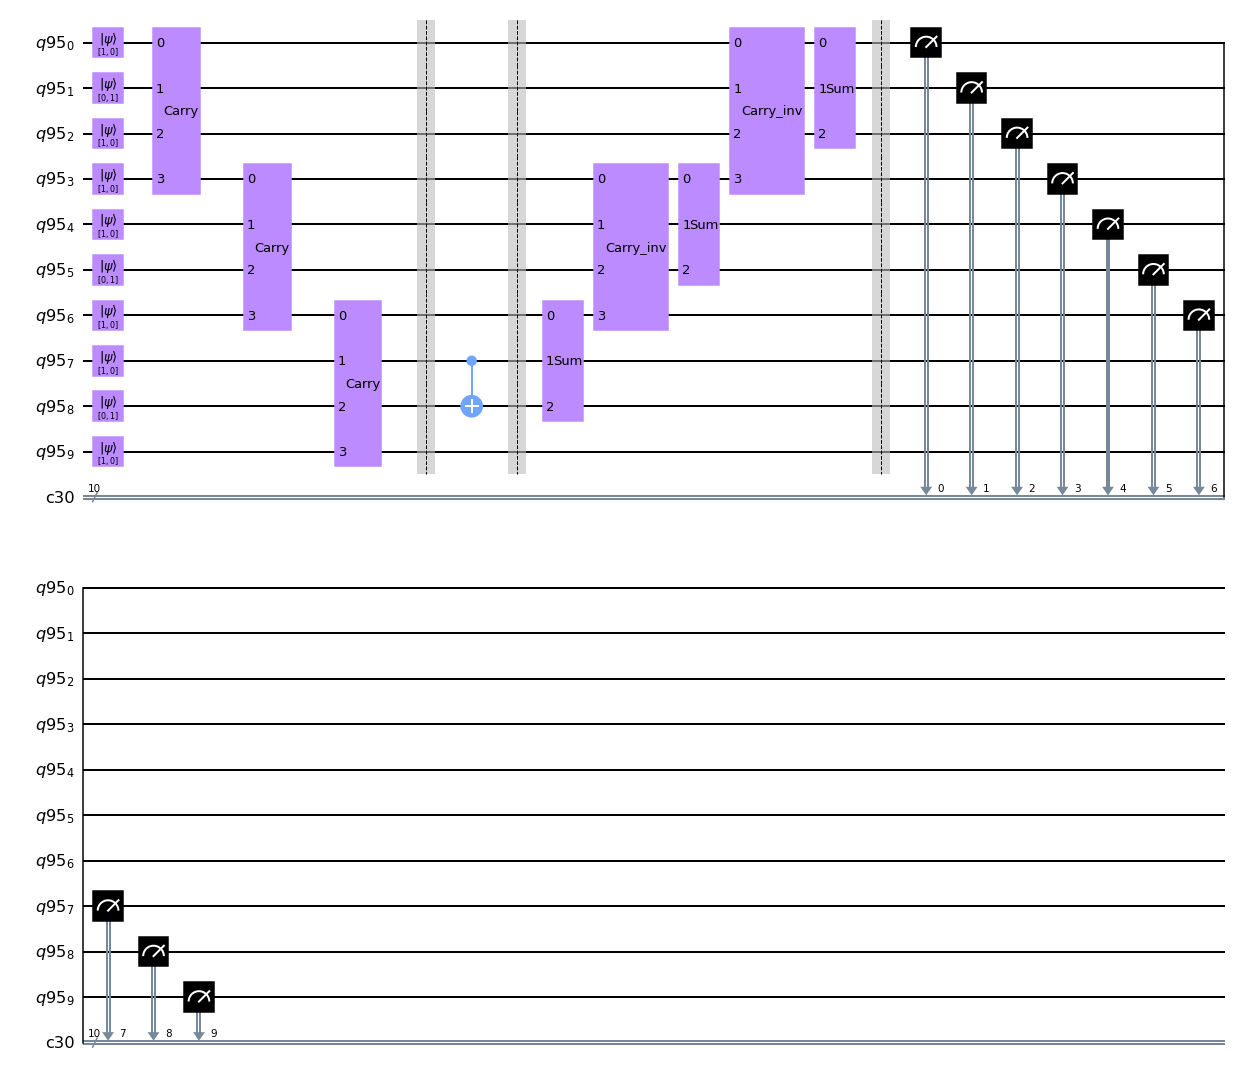

In [227]:
## a = 1, b = 6
qct2 = QuantumCircuit(qt2,ct2)
#qct.x(0)
qct2.initialize([1,0],0) # ancilla | ancilla 
qct2.initialize([0,1],1) #a0       | a0
qct2.initialize([1,0],2) #b0       | c0
qct2.initialize([1,0],3) # ancilla
qct2.initialize([1,0],4) #a1
qct2.initialize([0,1],5) #b1
qct2.initialize([1,0],6) # ancilla
qct2.initialize([1,0],7) #a2
qct2.initialize([0,1],8) #b2
qct2.initialize([1,0],9) # ancilla
##qct.x(3)
Addition_gate(qct2,10, 3)
qct2.barrier()
qct2.measure(range(10), range(10))
qct2.draw('mpl')

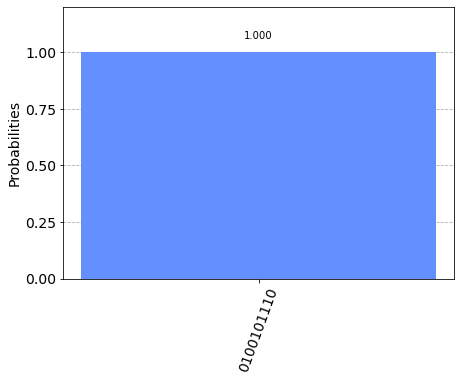

In [225]:
results = execute(qct2,backend = backend_sim, shots = N_shots).result()
#results.get_statevector()
counts = results.get_counts()
plot_histogram(counts)

In [226]:
results.get_counts()

{'0100101110': 10240}

Adding two 3 bit numbers with this circuit turns into a 4-bit number to account for overflow. To decipher c from this circuit, we know that the final wave function 

$0100101110$

$c_3c_2a_20c_1a_11c_0a_00$

This makes $c_3 = 0, c_2 = 1, c_1=1, c_0 = 1$, which means c = 0111 = 0 + 4 + 2 + 1 = 7. This is the result we set out before hand and proves we have made a quantum circuit that adds two non-negative numbers. 